In [355]:
import pandas as pd
df = pd.read_csv("df_lyrics.csv")
import nltk
nltk.download('punkt')
import re
from nltk.corpus import stopwords
import nltk.tokenize as nltk
import math
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /Users/zdrxxxi07/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zdrxxxi07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [356]:
from itertools import islice

def take(n, iterable):
    return list(islice(iterable, n))

def preprocessText(words):
    stop_words = set(stopwords.words('english'))
    # remove punctuation
    words = re.sub(r'[^\w\s-]', '', words)
    # remove numbers
    words = re.sub(r'\d+', '', words)
    # tokenize
    words = nltk.word_tokenize(words)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # split hyphen words
    final = []
    for word in words:
        if "-" in word:
            final.extend(word.split("-"))
        elif word == '':
            continue
        else:
            final.append(word)
    return final

In [357]:
content = pd.read_csv("rap_all.csv", encoding='unicode_escape')
content = content.dropna()

In [361]:
# create rap_word dictionary
# format: {rap_word_1: word count, rap_word_2: word count ...}
rap_words = dict()
for index,rapper_lyrics in tqdm(content.iterrows()):
    l = preprocessText(rapper_lyrics["text"])
    for word in l:
        try:
            rap_words[word] += 1
        except:
            rap_words[word] = 1   

0it [00:00, ?it/s]

In [362]:
# load stop words into a list, stopwords
stop_file = open("stop.txt", "r")
try:
    c = stop_file.read()
    my_stopwords = c.split(",")
finally:
    stop_file.close()

In [363]:
# create updated rap_words; pop/clean stopwords again
pop_l = list()
for k in sort_rap_words:
    if k.casefold() in my_stopwords:
        pop_l.append(k)
for w in pop_l:
    sort_rap_words.pop(w)

In [380]:
top_rap_words = take(len(sort_rap_words), sort_rap_words)

In [381]:
# rap_word occurence probability
total_rap_words = sum([sort_rap_words[k] for k in top_rap_words])
rap_words_probability = dict()
for k in top_rap_words:
    count = sort_rap_words[k]
    rap_words_probability[k] = count/total_rap_words

In [351]:
import math

# GOAL:
# need to read the data file and create TFIDF vectors for queries and abstracts

# format of data
# ARTIST, SONG, LYRICS, GENRE

# devote 20% of the data for testing
# the other 80% can be for development/training
df = pd.read_csv("df_lyrics.csv")

# need to shuffle the data
df = df.sample(frac=1, random_state=42)
# Reset the index after shuffling
df.reset_index(drop=True, inplace=True)

# then devote 20% to testing
# Calculate the number of rows for the test set (20% of the original DataFrame)
test_size = int(0.2 * len(df))

# Take a random sample of 20% of the rows for the test set
test_df = df.sample(n=test_size, random_state=42)

# Create the training set (80% of the original DataFrame)
train_df = df.drop(test_df.index)

# Reset the index of the training and test sets
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(train_df.shape[0])

# 13 percent of total are the query songs

# we need to separate queries and abstracts
# 9635 is approximately 15% of the length train_df
query_songs = train_df.head(100000)

# Remove the first 9635 rows from the original DataFrame
train_df = train_df.iloc[100000:]

# Reset the index of the dataframes
query_songs.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)

64228


In [352]:
query_songs

,Artist,Song,Lyrics,Genre
0,The Notorious B.I.G.,Playa Hater,"Good evening And for my last hit, I'd like to...",Rap
1,Led Zeppelin,Dazed and Confused (How the West Was Won),"Oooooh, I've been dazed and confused for so l...",Rock
2,Otis Redding,The Glory of Love,"Give a little, take a little And let your lit...",Rock
3,Bebe Rexha,Apples,Shoutout to Lauren cause she said it right Th...,Pop
4,Brian Eno,Here Come the Warm Jets,Further we make claims on our teas Dawn inner...,Rock
...,...,...,...,...
64223,Cypress Hill,Locotes,"""Hey, Ese look at these two motherfuckers rig...",Rap
64224,Tove Lo,Lies in the Dark,"Over, over, and again Over (aah) and again Ov...",Pop
64225,Souls of Mischief,Dirty Ds Theme (Hoe or Die),Artist: Souls of Mischief Album: No Man's Land...,Rap
64226,Usher,Stronger,"Been through hell, now I'm hell proof Pouring...",Pop


In [382]:
# calculate average ratio of rap_word occurence
rap_score_list = list()
rap_df = df[df["Genre"]=="Rap"]
for index,song in tqdm(rap_df.iterrows()):
    lyrics = preprocessText(song["Lyrics"])
    score = 0
    for word in lyrics:
        if(word in rap_words_probability.keys()):
            score += rap_words_probability[word]
    rap_score_list.append(score)

0it [00:00, ?it/s]

In [393]:
# this will act as a threshold
import numpy as np
rap_score_list = np.array(rap_score_list)
rap_score_reference = np.quantile(rap_score_list, 0.5)

In [394]:
rap_score_reference

0.03524235984225018

In [395]:
# test on rap_word_score
rap_predict_dict = dict()

for index,song in tqdm(query_songs.iterrows()):
    lyrics = preprocessText(song["Lyrics"])
    score = 0
    for word in lyrics:
        if(word in rap_words_probability.keys()):
            score += rap_words_probability[word]
    if(score >= rap_score_reference):
        rap_predict_dict[song["Song"]] = True
    else:
        rap_predict_dict[song["Song"]] = False

rap_answer = dict()
for i in query_songs.index:
    cur_song = query_songs.iloc[i]
    rap_answer[cur_song["Song"]] = cur_song["Genre"]

precision = [0,0] #[The count of True Positives, the count of false positives]
for k in rap_predict_dict:
    if(rap_predict_dict[k]):
        if(rap_answer[k] == 'Rap'):
            precision[0]+=1
        else:
            precision[1]+=1

0it [00:00, ?it/s]

In [396]:
print(precision[0]/sum(precision))
print(sum(precision))
# precision using top 100 rap word with 75 percentile: 78% with around 4.5k
# precision using top 100 rap word with 50 percentile: 67% with around 9.2k
# precision using all rap word with 75 percentile: 77% with around 4k
# precision using all rap word with 50 percentile: 72% with around 8.5k (choose this for now)

0.7263120817189151
8517


In [397]:
# Up until here, is only the filter using solely rap_word_probablity
# what i did was getting a rap song database (big enough I think), 
# get the word count after applying Preprocess function
# and based on the dictionary of {rap_word: count} 
# i calcualted each rap_word probablity within the whole distribution
# so say the total word count is 100, and word "shit" appears 5 times,
# then I will assign a probability of 0.05 to the word "shit"
# later I just go through each query song and calculated the probability-score for each
# and check if the song reach the threshold, which can be changed

In [398]:
# Start to consider from the lyrics length aspect
def preprocessTextwithStopWords(words):
    # remove punctuation
    words = re.sub(r'[^\w\s-]', '', words)
    # remove numbers
    words = re.sub(r'\d+', '', words)
    # tokenize
    words = nltk.word_tokenize(words)
    # split hyphen words
    final = []
    for word in words:
        if "-" in word:
            final.extend(word.split("-"))
        elif word=="":
            continue
        else:
            final.append(word)
    return final

In [401]:
#calculate the word count level of Rap Genre, and other genre
rap_word_count = list()
pop_word_count = list()
country_word_count = list()
rock_word_count = list()
for index,song in tqdm(df.iterrows()):
    lyrics = preprocessTextwithStopWords(song["Lyrics"])
    word_count = len(list(filter(lambda a: a != "", lyrics)))
    if(song["Genre"]=="Rap"):
        rap_word_count.append(word_count)
    elif(song["Genre"]=="Pop"):
        pop_word_count.append(word_count)
    elif(song["Genre"]=="Country"):
        country_word_count.append(word_count)
    else:
        rock_word_count.append(word_count)

rap_word_count = np.array(rap_word_count)
pop_word_count = np.array(pop_word_count)
country_word_count = np.array(country_word_count)
rock_word_count = np.array(rock_word_count)

0it [00:00, ?it/s]

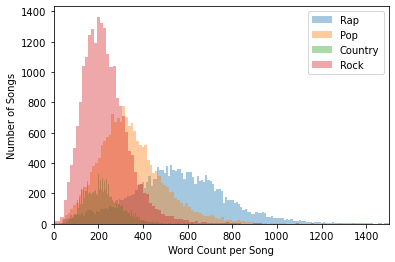

In [402]:
# plot the distribution
import matplotlib.pyplot as plt

# # plotting labelled histogram
plt.hist(rap_word_count, bins=500, label="Rap", alpha = 0.4)
plt.hist(pop_word_count, bins=500, label="Pop", alpha = 0.4)
plt.hist(country_word_count, bins=500, label="Country", alpha = 0.4)
plt.hist(rock_word_count, bins=500, label="Rock", alpha = 0.4)
plt.xlabel('Word Count per Song')
plt.ylabel('Number of Songs')
plt.xlim(0, 1500)
plt.legend(loc='best')
plt.show()

In [403]:
# these are the distribution of word counts per song for each genre
# note that stopwords are included since we do not care if it is a stopword or not
# the occurence of stopwords also is a factor from a linguistic aspect
rap_wc_reference = np.quantile(rap_word_count, 0.5)
pop_wc_reference = np.quantile(pop_word_count, 0.5)
country_wc_reference = np.quantile(country_word_count, 0.5)
rock_wc_reference = np.quantile(rock_word_count, 0.5)

In [404]:
print(rap_wc_reference)
print(pop_wc_reference)
print(country_wc_reference)
print(rock_wc_reference)

550.0
327.0
214.0
218.0


In [405]:
# set rap word count threshold to 600 temporarily based on the graph
rap_word_count_threshold = 600

In [406]:
# test on lyrics length
rap_answer
query_word_count = dict()

for index,song in tqdm(query_songs.iterrows()):
    lyrics = preprocessTextwithStopWords(song["Lyrics"])
    word_count = len(list(filter(lambda a: a != "", lyrics)))
    query_word_count[song["Song"]] = word_count

0it [00:00, ?it/s]

In [407]:
precision_lyricslen_most_likely = [0,0] #[The count of True Positives, the count of false positives]
precision_lyricslen_likely = [0,0] #[The count of True Positives, the count of false positives]
precision_lyricslen_neutral = [0,0] #[The count of True Positives, the count of false positives]

lyrics_len_prediction_most_likely = list()
lyrics_len_prediction_likely = list()
lyrics_len_prediction_neutral = list()

for k in tqdm(query_word_count):
    if(query_word_count[k] >= 600):
        lyrics_len_prediction_most_likely.append(k)
        if(rap_answer[k] == 'Rap'):
            precision_lyricslen_most_likely[0]+=1
        else:
            precision_lyricslen_most_likely[1]+=1
    elif(query_word_count[k] >= rap_wc_reference):
        lyrics_len_prediction_likely.append(k)
        if(rap_answer[k] == 'Rap'):
            precision_lyricslen_likely[0]+=1
        else:
            precision_lyricslen_likely[1]+=1
    elif(query_word_count[k] >= np.quantile(rap_word_count, 0.25)):
        lyrics_len_prediction_neutral.append(k)
        if(rap_answer[k] == 'Rap'):
            precision_lyricslen_neutral[0]+=1
        else:
            precision_lyricslen_neutral[1]+=1
            
print("Most Likely Precicsion:")
print(precision_lyricslen_most_likely[0]/sum(precision_lyricslen_most_likely))
print("Likely Precicsion:")
print(precision_lyricslen_likely[0]/sum(precision_lyricslen_likely))
print("Neutral Precicsion:")
print(precision_lyricslen_neutral[0]/sum(precision_lyricslen_neutral))

  0%|          | 0/52676 [00:00<?, ?it/s]

Most Likely Precicsion:
0.8525004209462873
Likely Precicsion:
0.7141963727329581
Neutral Precicsion:
0.5146557600545331


In [408]:
totalprecision = (precision_lyricslen_most_likely[0]+precision_lyricslen_likely[0]+precision_lyricslen_neutral[0])/(sum(precision_lyricslen_most_likely)+sum(precision_lyricslen_likely)+sum(precision_lyricslen_neutral))
totalprecision

0.688124720274504

In [409]:
# Up til this point, it is only the test based on the lyrics length
# Most Likely is any song with a word count bigger than 600
# Likely is any song with a word count bigger than the median of my rap_word_count distribution but smaller than 600
# Neutral is any song with a word count bigger than 25th percentile but smaller than the median of my rap_word_count distribution

In [410]:
# first the lyrics length count and then rap_word count method
from scipy.stats import percentileofscore
final_rap_predict_dict = dict()

for song in tqdm(lyrics_len_prediction_most_likely+lyrics_len_prediction_likely+lyrics_len_prediction_neutral):
    for k,s in query_songs[query_songs["Song"]==song].iterrows():
        lyrics = preprocessText(s["Lyrics"])
    lyrics = list(filter(lambda a: a != "", lyrics))
    score = 0
    for word in lyrics:
        if(word in sort_rap_words.keys()):
            score += sort_rap_words[word]
    final_rap_predict_dict[song] = score
    # so here my idea is to see what is the query song word count
    # and where is that word count within the whole rapsong_wordcount distribution
    # meaning compare to all rap songs what percentile can this word count reach
    w_c_percentile = percentileofscore(rap_word_count, query_word_count[song])
    final_rap_predict_dict[song] += (w_c_percentile/100) #standardize from say 90th percentile to 0.9
#     if(score >= rap_score_reference):
#         final_rap_predict_dict[song] = True
#     else:
#         final_rap_predict_dict[song] = False

  0%|          | 0/13406 [00:00<?, ?it/s]

In [411]:
# now this dictionary is sorted and 
# format is: {songname: word_count_percentile_score}
final_rap_predict_dict = {k: v for k, v in sorted(final_rap_predict_dict.items(), key=lambda item: item[1], reverse=True)}

In [412]:
final_precision = [0,0] #[The count of True Positives, the count of false positives]
for k in final_rap_predict_dict:
    # right now, i choose to see if the word_count_percentile score plus the rap_word_occurence score
    # if this sum is bigger than sum of rap_score_reference(which is the median for now) and 0.5(which 50th percentile)
    # if so we count that as a rap song prediction
    if(final_rap_predict_dict[k] > rap_score_reference+0.5):
        if(rap_answer[k] == 'Rap'):
            final_precision[0]+=1
        else:
            final_precision[1]+=1
final_precision[0]/sum(final_precision)

0.8245125348189415

In [413]:
final_precision #[true positive counts, false positive counts]

[6216, 1323]

In [415]:
# some things to consider
# i think as the very first step, we need to care about the volume of the prediction
# whether we want to prediction to be as accurate as possible?
# or do we want it to be not that accurate but filter out a decent amount?
# for now, I value the amount a bit more, not too bad with a 82.5% precision
# but can definitely improve

# some code may not be that clear/intuitive so ask any question in the chat!